In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import lstsq
from numpy.random import randn, seed
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib notebook
pd.options.display.float_format = '{:,.2f}'.format
seed(42)

In [2]:
# from jupyterthemes import jtplot
# jtplot.style(theme='onedork', context='talk', fscale=1.6, spines=False, 
#              gridlines='--', ticks=True, grid=False, figsize=(7, 5))

## Linear Projection: Principal Component Analysis

### Create Noisy, Correlated Data from Signal

In [3]:
colors = sns.color_palette("Paired")
dot_color = colors[0]
pc1_color = colors[-1]
pc1_color_alt = colors[-2]
pc2_color = colors[1]
proj_color = colors[1]

<IPython.core.display.Javascript object>


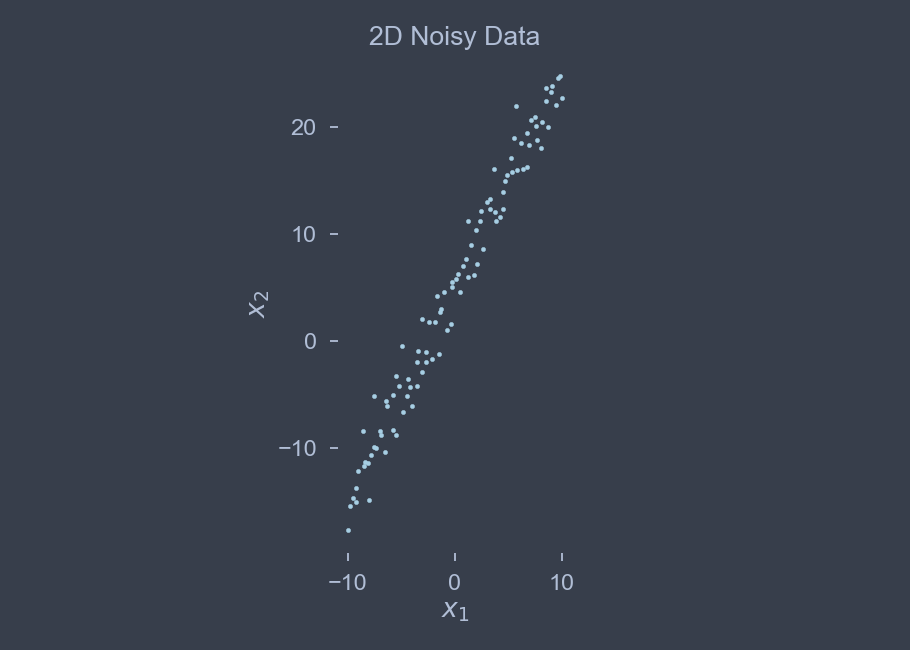

In [4]:
n_signals = 100
x1 = np.linspace(-10, 10, n_signals) + .1 * randn(n_signals)
x2 = 5 + 2 * x1 + 2 * randn(n_signals)
data = pd.DataFrame({'$x_1$': x1, '$x_2$': x2})
ax = data.plot.scatter(x=0, y=1, s=10, c=dot_color, title='2D Noisy Data')
ax.set_aspect('equal')
plt.tight_layout()

### Compute Principal Components 

In [5]:
pca = PCA()
pca.fit(data)
pca.components_

array([[-0.43950051, -0.89824234],
       [-0.89824234,  0.43950051]])

In [6]:
mean = pca.mean_
mean

array([-0.01038465,  5.02383987])

In [7]:
pc1, pc2 = np.split(pca.components_.T, 2, axis=1)
pc1

array([[-0.43950051],
       [-0.89824234]])

#### Check share of explained variance

In [8]:
pca.explained_variance_ratio_

array([0.99593589, 0.00406411])

### Components are orthogonal to each other

In [9]:
np.dot(pc1.T, pc2)

array([[0.]])

### Plot Principal Components as new Basis Vectors

In [10]:
l1, l2 = pca.singular_values_ / 10

<IPython.core.display.Javascript object>


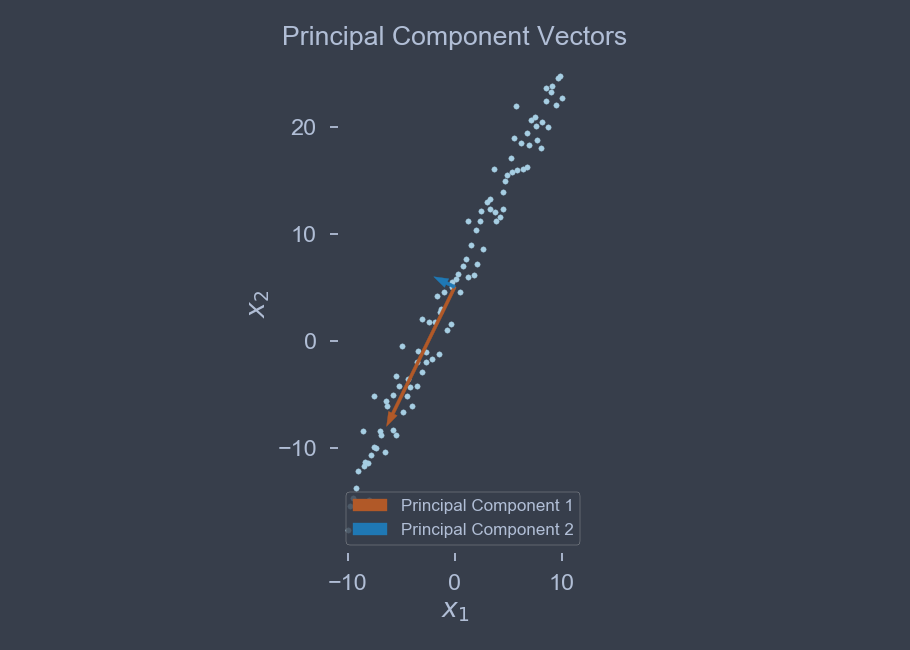

In [11]:
ax = data.plot.scatter(x=0, y=1, s=15, c=dot_color,
                       title='Principal Component Vectors')
ax.set_aspect('equal')
origin_x, origin_y = pca.mean_
dx1, dy1 = np.squeeze(pc1.T) * l1
dx2, dy2 = np.squeeze(pc2.T) * l2
pc1_arrow = ax.arrow(origin_x, origin_y, dx1, dy1, color=pc1_color, width=.3)
pc2_arrow = ax.arrow(origin_x, origin_y, dx2, dy2, color=pc2_color, width=.3)
plt.legend([pc1_arrow, pc2_arrow], ['Principal Component 1',
                                    'Principal Component 2'], 
           fontsize='x-small')
plt.tight_layout()

### Project 2D data onto the first Principal Component

<IPython.core.display.Javascript object>


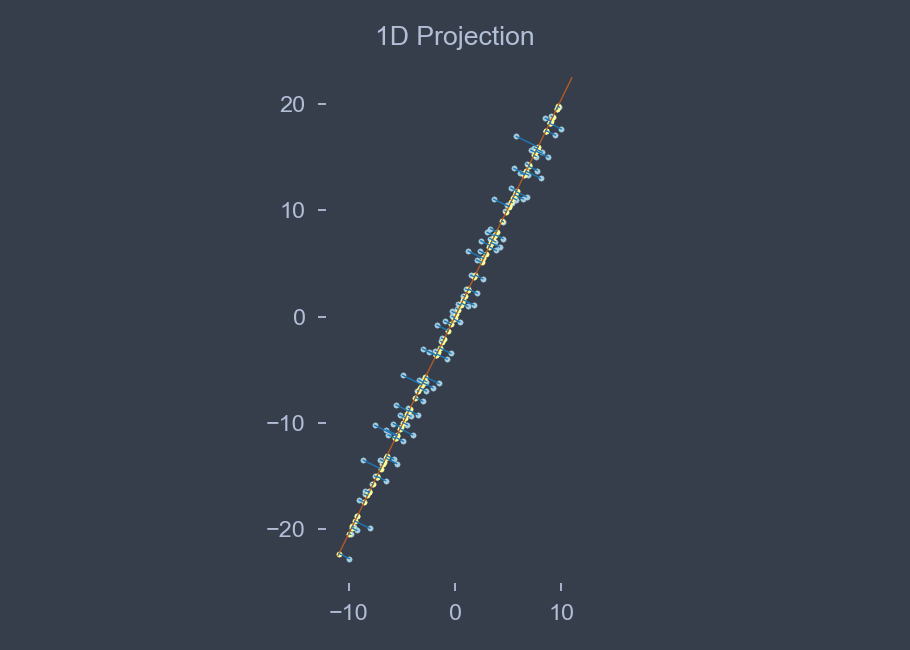

In [12]:
fig, ax = plt.subplots()

# de-mean data, convert to numpy array
data_ = data.sub(data.mean())
X_ = data_.values
x_, y_ = X_.T
ax.scatter(x=x_, y=y_, s=15, c=dot_color)
ax.set_title('1D Projection')
ax.set_aspect('equal')

# plot first component
t = np.linspace(-25, 25, n_signals)
pc_x, pc_y = t * pc1
ax.plot(pc_x, pc_y, c=pc1_color, lw=1)

# project original data on first component
proj_x, proj_y = (X_.dot(pc1) * pc1.T).T
ax.scatter(proj_x, proj_y, s=15, c=pc1_color_alt)

# plot link from data to projected points
lines_x, lines_y = np.c_[x_, proj_x], np.c_[y_, proj_y]
ax.plot(lines_x.T, lines_y.T,  c=proj_color, lw=1)
plt.tight_layout()

### Plot 1D Representation 

<IPython.core.display.Javascript object>


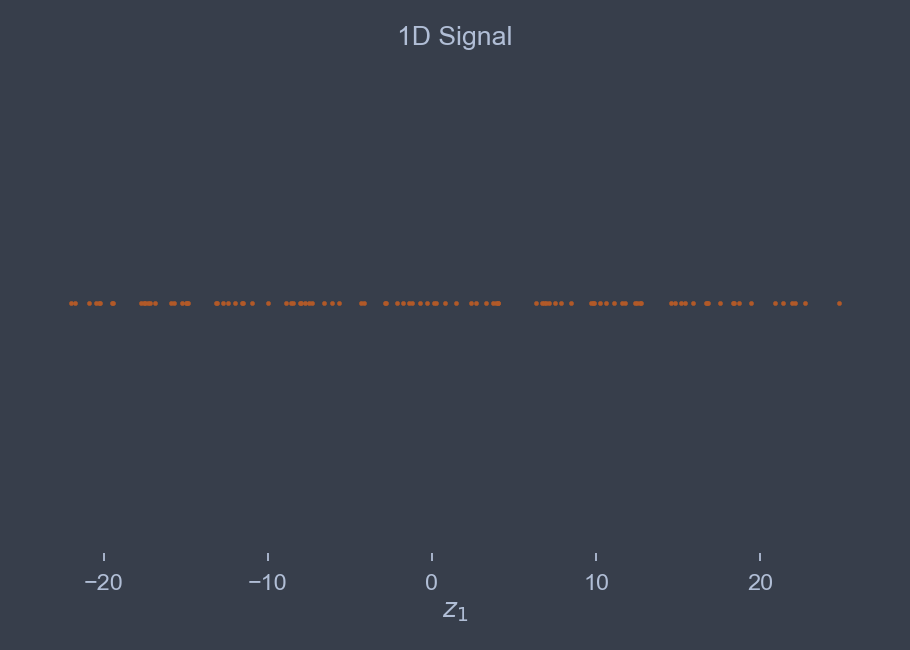

In [13]:
projection1D = data_.dot(pc1)
ax = projection1D.rename(columns={0: '$z_1$'})\
    .assign(x2=0).plot.scatter(x='$z_1$', y='x2',  c=pc1_color, s=10, title='1D Signal')
ax.get_yaxis().set_visible(False)
plt.tight_layout();

### Compare to Linear Regression

<IPython.core.display.Javascript object>


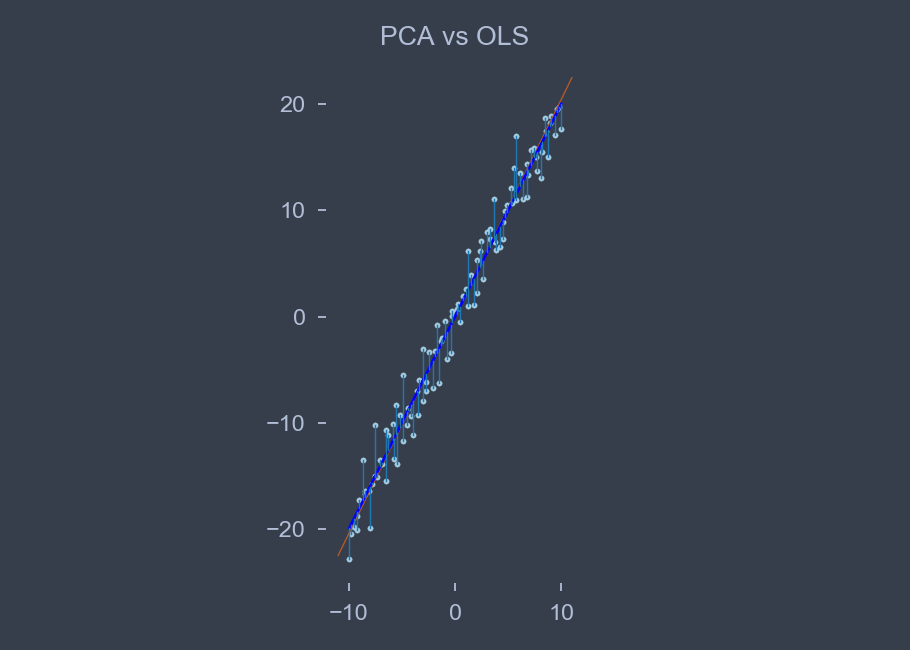

/home/stefan/.virtualenvs/unsupervised_learning/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


In [14]:
fig, ax = plt.subplots()
ax.scatter(x=x_, y=y_, s=15, c=dot_color)
ax.set_title('PCA vs OLS')
ax.set_aspect('equal')

# draw first principal component from origin
t = np.linspace(-25, 25, n_signals)
pc_x, pc_y = t * pc1
ax.plot(pc_x, pc_y, c=pc1_color, lw=1)

# get OLS line
reg_X = np.column_stack((x_, np.ones_like(x_)))
(m, b), _, _, _ = lstsq(reg_X, y_)
reg_y = m * x_ + b
ax.plot(x_, reg_y, c='blue')

# plot residuals
lines_x, lines_y = np.c_[x_, x_], np.c_[y_, reg_y]
ax.plot(lines_x.T, lines_y.T,  c=proj_color, lw=1)
plt.tight_layout()

### Recover Data using Inverse Transformation 1D => 2D

<IPython.core.display.Javascript object>


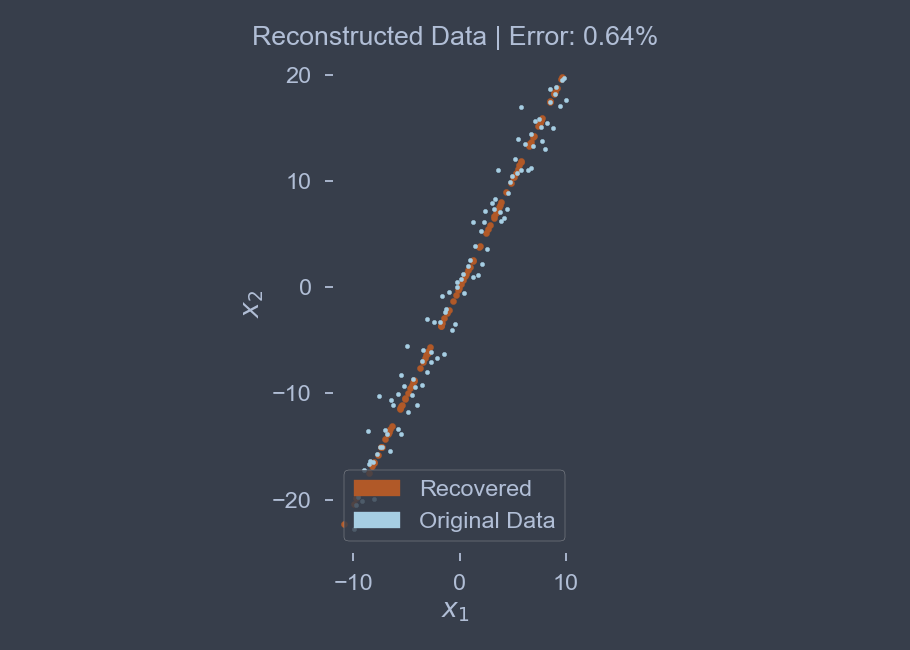

In [15]:
recovered_data = projection1D.dot(pc1.T).rename(columns={0: '$x_1$', 
                                                         1: '$x_2$'})
rms_reconstruction_error = np.sqrt(np.mean(np.sum(np.square(
                            recovered_data-data_), axis=1)))
rss_data = np.sqrt(np.sum(data_.values**2))
relative_loss = rms_reconstruction_error / rss_data
ax = recovered_data.plot.scatter(x=0, y=1, color=pc1_color, 
    title='Reconstructed Data | Error: {:.2%}'.format(relative_loss))
ax.set_aspect('equal')
data_.plot.scatter(x=0, y=1, s=10, c=dot_color, ax=ax)
plt.legend(handles=[Patch(color=pc1_color, label='Recovered'),  
                    Patch(color=dot_color, label='Original Data')])
plt.tight_layout()

### Projection and inverse transformation lead to the same result

In [16]:
np.allclose(recovered_data, X_.dot(pc1) * pc1.T)

True